In [145]:
# cell 1: imports, plotting style, seeds, device

# keep imports minimal and standard
import os, json, math, random, copy, time
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt

# icml style plotting prefs you asked for
matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})

# seeds for repeat runs
SEED = 27100162
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

# small helpers to ensure dirs exist
os.makedirs("figures_task4", exist_ok=True)
os.makedirs("artifacts_task4", exist_ok=True)


device: cuda


In [146]:
# cell 2 (patched): tiny cnn with two pools so fc1 sees 64*8*8

import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2)             # will apply twice to get 32->16->8
        self.dropout = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)  # matches 8x8 now
        self.fc2   = nn.Linear(128, num_classes)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)                         # first downsample 32->16
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)                         # second downsample 16->8
        x = x.view(x.size(0), -1)                # flatten 64*8*8
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x


In [147]:
# cell 3: load cifar10 test set and create a moderate train subset for speed

# train tfms same flavor as task 3
train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

data_root = "./data"
try:
    full_train = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tfms)
    test_set   = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)
except Exception as e:
    print("dataset download failed using local cache", e)
    full_train = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_tfms)
    test_set   = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=test_tfms)

# this subset size keeps things quick but still meaningful
SUBSET_TRAIN_SIZE = 25000  # adjust up if you want stronger accuracy
all_idx = np.arange(len(full_train))
np.random.shuffle(all_idx)
subset_indices = all_idx[:SUBSET_TRAIN_SIZE].tolist()

# get labels for those indices directly from raw targets of cifar10
raw_targets = np.array(full_train.targets)
subset_labels = raw_targets[subset_indices].astype(int)

train_set = Subset(full_train, subset_indices)  # apply transforms from full_train

# global test loader simple and stable
test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=0, pin_memory=False)

print("train subset size:", len(train_set), "test size:", len(test_set))


train subset size: 25000 test size: 10000


In [148]:
# cell 4: dirichlet partition of the subset to simulate label skew

def dirichlet_partition_indices(labels: np.ndarray, M: int, alpha: float, min_per_client_class: int = 5, seed: int = SEED) -> List[List[int]]:
    # labels is numpy array for the subset order, values 0..9
    rng = np.random.default_rng(seed)
    num_classes = int(labels.max() + 1)
    # collect positions per class in the subset order
    class_pos = {c: np.where(labels == c)[0].tolist() for c in range(num_classes)}
    for c in range(num_classes):
        rng.shuffle(class_pos[c])  # shuffle positions within class

    client_bins = [[] for _ in range(M)]

    for c in range(num_classes):
        pos = class_pos[c]
        n_c = len(pos)
        if n_c == 0:
            continue
        props = (np.ones(M) / M) if alpha >= 1e6 else rng.dirichlet(alpha * np.ones(M))
        raw = props * n_c
        counts = np.floor(raw).astype(int)
        leftover = n_c - counts.sum()
        if leftover > 0:
            order = np.argsort(-(raw - counts))
            for k in order[:leftover]:
                counts[k] += 1

        # enforce a tiny floor in a soft way for diversity
        need, give = [], []
        for i in range(M):
            if counts[i] == 0 and n_c >= min_per_client_class:
                need.append(i)
            elif counts[i] > min_per_client_class:
                give.append(i)
        for i in need:
            if not give:
                break
            j = give[-1]
            if counts[j] - 1 >= min_per_client_class:
                counts[j] -= 1
                counts[i] += 1
                if counts[j] == min_per_client_class:
                    give.pop()

        start = 0
        for i in range(M):
            take = counts[i]
            if take > 0:
                client_bins[i].extend(pos[start:start + take])
                start += take

    # final shuffle per client
    for i in range(M):
        rng.shuffle(client_bins[i])

    # if any client ended empty borrow a small slice from the largest
    for i in range(M):
        if len(client_bins[i]) == 0:
            sizes = [len(b) for b in client_bins]
            j = int(np.argmax(sizes))
            cut = max(1, sizes[j] // 10)
            moved = client_bins[j][:cut]
            client_bins[j] = client_bins[j][cut:]
            client_bins[i].extend(moved)

    return client_bins


In [149]:
# cell 5: helpers for state handling, evaluation, vectorization

def copy_state(model: nn.Module) -> Dict[str, torch.Tensor]:
    return {k: v.detach().clone() for k, v in model.state_dict().items()}

def load_state(model: nn.Module, state: Dict[str, torch.Tensor]):
    model.load_state_dict({k: v.clone() for k, v in state.items()}, strict=True)

def float_keys(state: Dict[str, torch.Tensor]) -> List[str]:
    ks = []
    for k, v in state.items():
        if v.dtype.is_floating_point:  # only floats for vector ops and averaging
            ks.append(k)
    return ks

def state_to_vector_float(state: Dict[str, torch.Tensor]) -> torch.Tensor:
    ks = float_keys(state)
    return torch.cat([state[k].view(-1).float() for k in ks])

def l2_state_diff_float(a: Dict[str, torch.Tensor], b: Dict[str, torch.Tensor]) -> float:
    va = state_to_vector_float(a)
    vb = state_to_vector_float(b)
    return torch.norm(va - vb, p=2).item()

@torch.no_grad()
def evaluate_state_on_loader(state: Dict[str, torch.Tensor], loader: DataLoader, device=DEVICE) -> Tuple[float, float]:
    model = SmallCNN().to(device)
    load_state(model, state)
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    crit = nn.CrossEntropyLoss(reduction="sum")
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss_sum += crit(logits, yb).item()
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return loss_sum / total, correct / total


In [150]:
# cell 5: helpers for state handling, evaluation, vectorization

def copy_state(model: nn.Module) -> Dict[str, torch.Tensor]:
    return {k: v.detach().clone() for k, v in model.state_dict().items()}

def load_state(model: nn.Module, state: Dict[str, torch.Tensor]):
    model.load_state_dict({k: v.clone() for k, v in state.items()}, strict=True)

def float_keys(state: Dict[str, torch.Tensor]) -> List[str]:
    ks = []
    for k, v in state.items():
        if v.dtype.is_floating_point:  # only floats for vector ops and averaging
            ks.append(k)
    return ks

def state_to_vector_float(state: Dict[str, torch.Tensor]) -> torch.Tensor:
    ks = float_keys(state)
    return torch.cat([state[k].view(-1).float() for k in ks])

def l2_state_diff_float(a: Dict[str, torch.Tensor], b: Dict[str, torch.Tensor]) -> float:
    va = state_to_vector_float(a)
    vb = state_to_vector_float(b)
    return torch.norm(va - vb, p=2).item()

@torch.no_grad()
def evaluate_state_on_loader(state: Dict[str, torch.Tensor], loader: DataLoader, device=DEVICE) -> Tuple[float, float]:
    model = SmallCNN().to(device)
    load_state(model, state)
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    crit = nn.CrossEntropyLoss(reduction="sum")
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss_sum += crit(logits, yb).item()
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return loss_sum / total, correct / total


In [151]:
# cell 6: safe weighted aggregation and client loader builder

def server_aggregate_weighted(client_states: List[Tuple[int, Dict[str, torch.Tensor]]],
                              client_sizes: Dict[int, int]) -> Dict[str, torch.Tensor]:
    # average floats only, copy non floats from first client
    keys = list(client_states[0][1].keys())
    float_ks = [k for k in keys if client_states[0][1][k].dtype.is_floating_point]
    nonfloat_ks = [k for k in keys if not client_states[0][1][k].dtype.is_floating_point]

    # init float accumulators
    agg = {k: torch.zeros_like(client_states[0][1][k], dtype=torch.float32) for k in float_ks}
    total = float(sum(client_sizes[cid] for cid, _ in client_states))

    for cid, st in client_states:
        w = float(client_sizes[cid]) / total
        for k in float_ks:
            agg[k] += st[k].detach().clone().float() * w

    # build output
    out = {}
    for k in float_ks:
        out[k] = agg[k].to(client_states[0][1][k].dtype)
    # take non float buffers from first client unchanged
    for k in nonfloat_ks:
        out[k] = client_states[0][1][k].detach().clone()
    return out

def build_client_subsets_and_loaders(subset_ds: Subset,
                                     client_pos_lists: List[List[int]],
                                     batch_size: int,
                                     shuffle: bool = True) -> Tuple[List[Subset], List[DataLoader]]:
    # subset.indices maps subset positions to original cifar positions; we want subset positions
    client_subsets = []
    client_loaders = []
    for plist in client_pos_lists:
        # the Subset expects indices into the original dataset (full_train), but our Subset is already a view
        # so we need to map subset positions to the original indices
        mapped = [subset_ds.indices[p] for p in plist]
        ds_i = Subset(subset_ds.dataset, mapped)
        client_subsets.append(ds_i)
        loader_i = DataLoader(ds_i, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=False)
        client_loaders.append(loader_i)
    return client_subsets, client_loaders


In [152]:
# cell 7: local client train step for fedprox

def local_train_fedprox(global_state: Dict[str, torch.Tensor],
                        client_loader: DataLoader,
                        K: int,
                        lr: float,
                        momentum: float,
                        weight_decay: float,
                        mu: float,
                        device=DEVICE) -> Tuple[Dict[str, torch.Tensor], float]:
    # clone model from global
    model = SmallCNN().to(device)
    load_state(model, global_state)
    model.train()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    # cache global params tensors on device for prox term
    with torch.no_grad():
        global_params = {k: v.detach().clone().to(device) for k, v in global_state.items() if v.dtype.is_floating_point}

    for _ in range(K):
        for xb, yb in client_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = ce(logits, yb)
            if mu > 0.0:
                prox = 0.0
                for (name, p) in model.named_parameters():
                    if p.requires_grad:
                        gp = global_params.get(name, None)
                        if gp is not None:
                            prox = prox + torch.sum((p - gp) ** 2)  # sum of squared distances
                loss = loss + (mu / 2.0) * prox
            loss.backward()
            opt.step()

    # compute drift relative to start of round
    new_state = copy_state(model)
    drift = l2_state_diff_float(new_state, global_state)
    return new_state, drift


In [153]:
# cell 8: run a fedprox experiment for one alpha and one mu

def run_fedprox_experiment(alpha: float,
                           mu: float,
                           rounds: int,
                           K: int,
                           M: int,
                           batch_size: int,
                           lr: float,
                           momentum: float,
                           weight_decay: float,
                           theta0: Dict[str, torch.Tensor] = None,
                           seed: int = SEED) -> Tuple[Dict, Dict[str, torch.Tensor]]:
    # fix seeds per run for determinism
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # partition the subset once for this alpha using subset_labels from cell 3
    client_pos_lists = dirichlet_partition_indices(subset_labels, M=M, alpha=alpha, min_per_client_class=5, seed=seed)
    client_subsets, client_loaders = build_client_subsets_and_loaders(train_set, client_pos_lists, batch_size=batch_size, shuffle=True)
    client_sizes = {i: len(client_subsets[i]) for i in range(M)}

    # init global model
    global_model = SmallCNN().to(DEVICE)
    if theta0 is None:
        theta0 = copy_state(global_model)
    load_state(global_model, theta0)
    global_state = copy_state(global_model)

    # logs for this run
    log = {
        "alpha": alpha,
        "mu": mu,
        "round": [],
        "test_acc": [],
        "avg_drift": [],
        "client_sizes": client_sizes,
        "final_state": None
    }

    # eval round 0
    _, acc0 = evaluate_state_on_loader(global_state, test_loader, device=DEVICE)
    print(f"[alpha={alpha} mu={mu}] round 0 acc={acc0:.4f}")
    log["round"].append(0)
    log["test_acc"].append(acc0)
    log["avg_drift"].append(0.0)

    for t in range(1, rounds + 1):
        client_states = []
        drifts = []
        # full participation for clarity
        for cid in range(M):
            st_i, drift_i = local_train_fedprox(global_state,
                                                client_loaders[cid],
                                                K=K, lr=lr, momentum=momentum,
                                                weight_decay=weight_decay, mu=mu, device=DEVICE)
            client_states.append((cid, st_i))
            drifts.append(drift_i)

        # aggregate then eval
        global_state = server_aggregate_weighted(client_states, client_sizes)
        _, acc_t = evaluate_state_on_loader(global_state, test_loader, device=DEVICE)
        avg_drift = float(np.mean(drifts)) if len(drifts) > 0 else 0.0

        log["round"].append(t)
        log["test_acc"].append(acc_t)
        log["avg_drift"].append(avg_drift)
        print(f"[alpha={alpha} mu={mu}] round {t:02d} acc={acc_t:.4f} drift={avg_drift:.3e}")

    log["final_state"] = global_state  # keep for chained inits
    return log, theta0


In [154]:
# cell 9: plotting helpers per alpha

def plot_acc_curves_for_alpha(alpha: float, logs_for_alpha: Dict[float, Dict], save_path: str = None):
    # one curve per mu
    plt.figure(figsize=(6.0, 4.0))
    for mu, lg in sorted(logs_for_alpha.items(), key=lambda x: x[0]):
        rounds = lg["round"]
        accs = lg["test_acc"]
        label = f"mu={mu}"
        plt.plot(rounds, accs, marker=None, linewidth=1.8, label=label)
    plt.xlabel("Rounds")   # capitalized labels for icml style
    plt.ylabel("Test Accuracy")
    plt.grid(True, alpha=0.25)
    plt.legend(frameon=False)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def plot_final_acc_bar_for_alpha(alpha: float, logs_for_alpha: Dict[float, Dict], save_path: str = None):
    mus = []
    finals = []
    for mu, lg in sorted(logs_for_alpha.items(), key=lambda x: x[0]):
        mus.append(mu)
        finals.append(lg["test_acc"][-1])
    x = np.arange(len(mus))
    plt.figure(figsize=(5.2, 4.0))
    plt.bar(x, finals)
    plt.xticks(x, [f"{m}" for m in mus])
    plt.xlabel("Mu")
    plt.ylabel("Final Test Accuracy")
    plt.grid(axis="y", alpha=0.25)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


[alpha=100.0 mu=0.0] round 0 acc=0.1026
[alpha=100.0 mu=0.0] round 01 acc=0.3823 drift=1.669e+01
[alpha=100.0 mu=0.0] round 02 acc=0.5208 drift=5.306e+00
[alpha=100.0 mu=0.0] round 03 acc=0.5538 drift=4.699e+00
[alpha=100.0 mu=0.0] round 04 acc=0.5980 drift=4.200e+00
[alpha=100.0 mu=0.0] round 05 acc=0.6302 drift=4.108e+00
[alpha=100.0 mu=0.0] round 06 acc=0.6402 drift=3.861e+00
[alpha=100.0 mu=0.0] round 07 acc=0.6637 drift=3.699e+00
[alpha=100.0 mu=0.0] round 08 acc=0.6657 drift=3.496e+00
[alpha=100.0 mu=0.0] round 09 acc=0.6736 drift=3.561e+00
[alpha=100.0 mu=0.0] round 10 acc=0.6830 drift=3.508e+00
[alpha=100.0 mu=0.0] round 11 acc=0.6910 drift=3.500e+00
[alpha=100.0 mu=0.0] round 12 acc=0.6990 drift=3.467e+00
[alpha=100.0 mu=0.01] round 0 acc=0.1026
[alpha=100.0 mu=0.01] round 01 acc=0.3711 drift=1.659e+01
[alpha=100.0 mu=0.01] round 02 acc=0.4986 drift=4.997e+00
[alpha=100.0 mu=0.01] round 03 acc=0.5449 drift=4.346e+00
[alpha=100.0 mu=0.01] round 04 acc=0.5880 drift=3.877e+00
[al

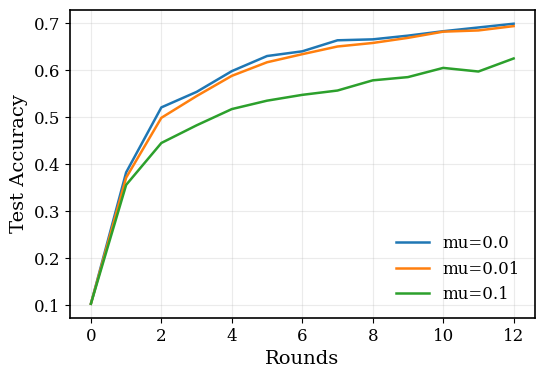

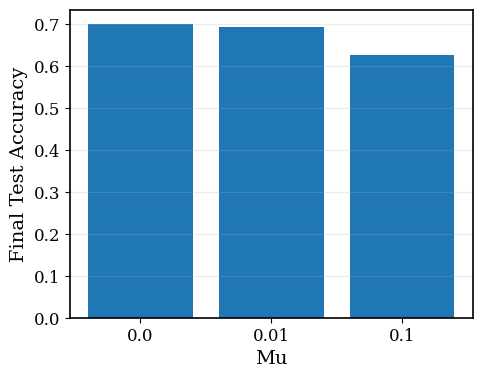

[alpha=0.1 mu=0.0] round 0 acc=0.1026
[alpha=0.1 mu=0.0] round 01 acc=0.2321 drift=1.726e+01
[alpha=0.1 mu=0.0] round 02 acc=0.3545 drift=5.643e+00
[alpha=0.1 mu=0.0] round 03 acc=0.3703 drift=4.432e+00
[alpha=0.1 mu=0.0] round 04 acc=0.4055 drift=4.227e+00
[alpha=0.1 mu=0.0] round 05 acc=0.4493 drift=4.023e+00
[alpha=0.1 mu=0.0] round 06 acc=0.4459 drift=3.736e+00
[alpha=0.1 mu=0.0] round 07 acc=0.4835 drift=3.650e+00
[alpha=0.1 mu=0.0] round 08 acc=0.4819 drift=3.587e+00
[alpha=0.1 mu=0.0] round 09 acc=0.5265 drift=3.521e+00
[alpha=0.1 mu=0.0] round 10 acc=0.5101 drift=3.436e+00
[alpha=0.1 mu=0.0] round 11 acc=0.5393 drift=3.328e+00
[alpha=0.1 mu=0.0] round 12 acc=0.5291 drift=3.327e+00
[alpha=0.1 mu=0.01] round 0 acc=0.1026
[alpha=0.1 mu=0.01] round 01 acc=0.2357 drift=1.672e+01
[alpha=0.1 mu=0.01] round 02 acc=0.3584 drift=5.057e+00
[alpha=0.1 mu=0.01] round 03 acc=0.3668 drift=4.123e+00
[alpha=0.1 mu=0.01] round 04 acc=0.4450 drift=3.890e+00
[alpha=0.1 mu=0.01] round 05 acc=0.4206

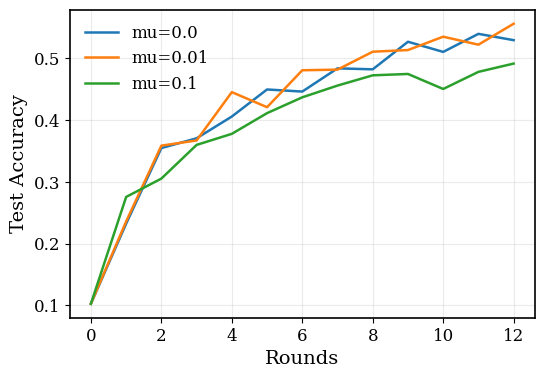

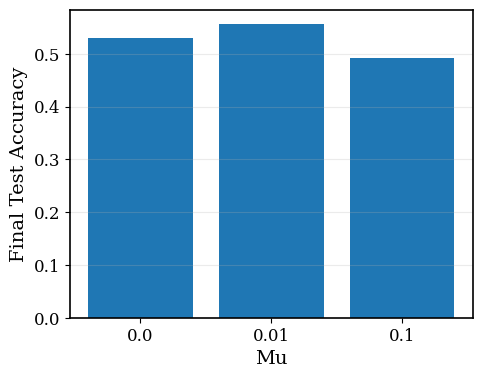

saved logs to artifacts_task4/fedprox_results.json


In [155]:
# cell 10: run fedprox vs fedavg experiments required by task 4.1

# config friendly to speed but still meaningful
M = 5                # clients
K = 4                # local epochs
ROUNDS = 12          # comm rounds
BATCH_SIZE = 64
LR = 0.01
MOMENTUM = 0.9
WD = 5e-4

ALPHAS = [100.0, 0.1]              # iid and highly skewed
MU_VALUES = [0.0, 0.01, 0.1]       # fedavg baseline and two fedprox strengths

results = {}        # results[alpha][mu] = log

for alpha in ALPHAS:
    results[alpha] = {}
    theta0_for_alpha = None  # share same init across mu values for fairness
    for mu in MU_VALUES:
        log, theta0_for_alpha = run_fedprox_experiment(alpha=alpha,
                                                       mu=mu,
                                                       rounds=ROUNDS,
                                                       K=K,
                                                       M=M,
                                                       batch_size=BATCH_SIZE,
                                                       lr=LR,
                                                       momentum=MOMENTUM,
                                                       weight_decay=WD,
                                                       theta0=theta0_for_alpha,
                                                       seed=SEED)
        results[alpha][mu] = log

    # plot curves and bar for this alpha
    png_curve = f"figures_task4/acc_vs_rounds_task4_fedprox_alpha_{alpha}.png"
    plot_acc_curves_for_alpha(alpha, results[alpha], png_curve)
    png_bar = f"figures_task4/final_acc_bar_task4_fedprox_alpha_{alpha}.png"
    plot_final_acc_bar_for_alpha(alpha, results[alpha], png_bar)

# save logs excluding final state tensors to keep json small
to_save = {}
for a, mp in results.items():
    to_save[str(a)] = {}
    for mu, lg in mp.items():
        d = {k: v for k, v in lg.items() if k != "final_state"}
        to_save[str(a)][str(mu)] = d

with open("artifacts_task4/fedprox_results.json", "w") as f:
    json.dump(to_save, f)
print("saved logs to artifacts_task4/fedprox_results.json")


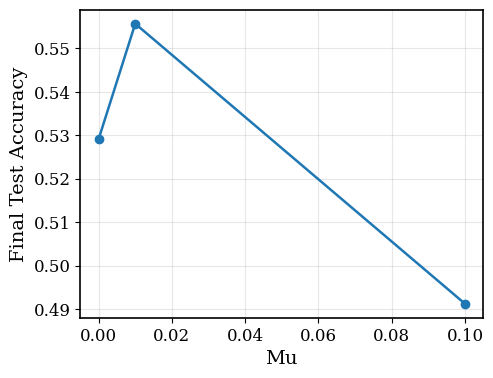

In [156]:
# cell 11: quick sensitivity plot of mu on a chosen alpha for the report

# pick alpha 0.1 which is the hard non iid case per manual
alpha_hard = 0.1
if alpha_hard in results:
    mus = sorted(results[alpha_hard].keys())
    finals = [results[alpha_hard][m]["test_acc"][-1] for m in mus]
    plt.figure(figsize=(5.2, 4.0))
    plt.plot(mus, finals, marker="o", linewidth=1.8)
    plt.xlabel("Mu")                 # icml style cap labels
    plt.ylabel("Final Test Accuracy")
    plt.grid(True, alpha=0.3)
    sp = f"figures_task4/mu_sensitivity_alpha_{alpha_hard}.png"
    plt.savefig(sp, bbox_inches="tight")
    plt.show()


In [157]:
# cell 12: dump a compact table style printout for the paper numbers

def print_summary_table(res: Dict):
    rows = []
    for a in sorted(res.keys()):
        for mu in sorted(res[a].keys()):
            lg = res[a][mu]
            final_acc = lg["test_acc"][-1]
            drift_mean = float(np.mean(lg["avg_drift"][1:])) if len(lg["avg_drift"]) > 1 else 0.0
            rows.append((a, mu, final_acc, drift_mean))
    # pretty print
    print("alpha   mu      final_acc   mean_drift")
    for a, mu, acc, dr in rows:
        print(f"{a:<6} {mu:<6}  {acc:>9.4f}  {dr:>10.3e}")

print_summary_table(results)


alpha   mu      final_acc   mean_drift
0.1    0.0        0.5291   5.014e+00
0.1    0.01       0.5557   4.679e+00
0.1    0.1        0.4912   3.800e+00
100.0  0.0        0.6990   5.008e+00
100.0  0.01       0.6939   4.748e+00
100.0  0.1        0.6250   3.437e+00
